In [1]:
import janus
import os
import timeit
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.signal import argrelmax,find_peaks,argrelmin
import imp
from scipy.sparse import csr_matrix
plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

imp.reload(janus)

<module 'janus' from '/Users/zack/Documents/oscillators/snakingoscillators/janus.py'>

### A limit-cycle chimera state

runtime: 34.425949


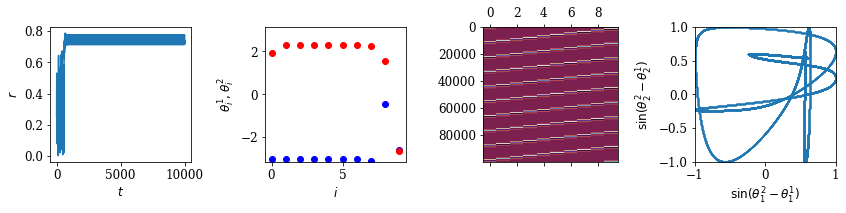

In [2]:
N=10
k=1
t1=10000
t3=9000
dt=0.01
sigma=0.35
beta=0.25
gamma=0.1
output=2
seed=1
omega=1

np.random.seed(seed)
phase_init = np.zeros(4*N,dtype=np.float64)
phi0=-np.pi+2*np.pi*np.random.random(N)
phi1=-np.pi+2*np.pi*np.random.random(N)
phase_init[:N] = np.cos(phi0)
phase_init[N:2*N] = np.sin(phi0)
phase_init[2*N:3*N] = np.cos(phi1)
phase_init[3*N:] = np.sin(phi1)

start = timeit.default_timer()
phases,times,order=janus.runsim(N, t1, t3, dt, omega, beta, sigma, gamma, phase_init)
stop = timeit.default_timer()
print('runtime: %f' % (stop - start))

phases=phases[int(t3/dt):]

phi0=np.arctan2(phases[:,N:2*N],phases[:,:N])
phi1=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])

plt.subplots(1,4,figsize=(12,3))
plt.subplot(1,4,1)
plt.xlabel('$t$')
plt.ylabel('$r$')
plt.plot(times,order)
plt.subplot(1,4,2)
plt.xlabel('$i$')
plt.ylabel(r'$\theta_i^1, \theta_i^2$')
plt.ylim(-np.pi,np.pi)
plt.plot(phi0[-1],'bo')
plt.plot(phi1[-1],'ro')
plt.subplot(1,4,3)
ratio=N/len(phases)
plt.gca().matshow(phi1,aspect=ratio,vmin=-np.pi,vmax=np.pi,cmap='twilight_shifted')
plt.subplot(1,4,4)
plt.xlabel(r'$\sin(\theta_1^2-\theta_1^1)$')
plt.ylabel(r'$\sin(\theta_2^2-\theta_2^1)$')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(np.cos(phi1[:,0]-phi0[:,0]),np.cos(phi1[:,1]-phi0[:,1]),s=0.1)
plt.tight_layout()
plt.show()

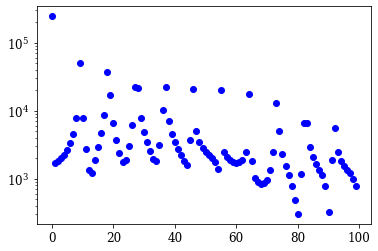

In [3]:
plt.yscale('log')
plt.plot(np.abs(np.fft.fft(phi0,axis=0))[:100,0],'bo')

### A chaotic or invariant torus chimera state

runtime: 33.317393


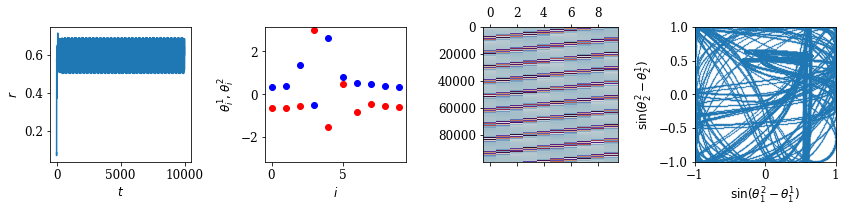

In [4]:
N=10
k=1
t1=10000
t3=9000
dt=0.01
sigma=0.35
beta=0.25
gamma=0.1
output=2
seed=9
omega=1

np.random.seed(seed)
phase_init = np.zeros(4*N,dtype=np.float64)
phi0=-np.pi+2*np.pi*np.random.random(N)
phi1=-np.pi+2*np.pi*np.random.random(N)
phase_init[:N] = np.cos(phi0)
phase_init[N:2*N] = np.sin(phi0)
phase_init[2*N:3*N] = np.cos(phi1)
phase_init[3*N:] = np.sin(phi1)

start = timeit.default_timer()
phases,times,order=janus.runsim(N, t1, t3, dt, omega, beta, sigma, gamma, phase_init)
stop = timeit.default_timer()
print('runtime: %f' % (stop - start))

phases=phases[int(t3/dt):]

phi0=np.arctan2(phases[:,N:2*N],phases[:,:N])
phi1=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])

plt.subplots(1,4,figsize=(12,3))
plt.subplot(1,4,1)
plt.xlabel('$t$')
plt.ylabel('$r$')
plt.plot(times,order)
plt.subplot(1,4,2)
plt.xlabel('$i$')
plt.ylabel(r'$\theta_i^1, \theta_i^2$')
plt.ylim(-np.pi,np.pi)
plt.plot(phi0[-1],'bo')
plt.plot(phi1[-1],'ro')
plt.subplot(1,4,3)
ratio=N/len(phases)
plt.gca().matshow(phi1,aspect=ratio,vmin=-np.pi,vmax=np.pi,cmap='twilight_shifted')
plt.subplot(1,4,4)
plt.xlabel(r'$\sin(\theta_1^2-\theta_1^1)$')
plt.ylabel(r'$\sin(\theta_2^2-\theta_2^1)$')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(np.cos(phi1[:,0]-phi0[:,0]),np.cos(phi1[:,1]-phi0[:,1]),s=0.1)
plt.tight_layout()
plt.show()

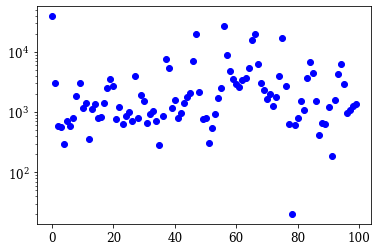

In [5]:
plt.yscale('log')
plt.plot(np.abs(np.fft.fft(phi0,axis=0))[:100,0],'bo')

### The limit-cycle chimera can be found numerically as a boundary value problem

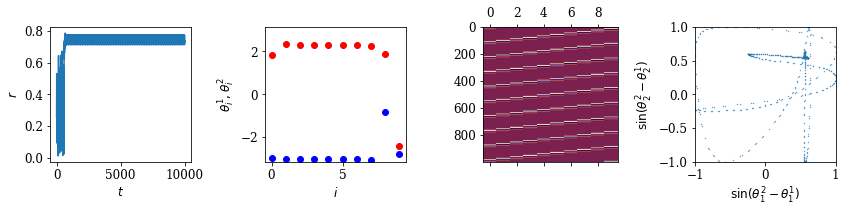

(array([ 6, 13, 20, 27, 34, 41, 48, 55, 62]),)

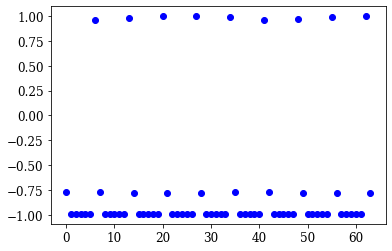

In [6]:
filebase='data/chimera/'
times=np.load(filebase+'times.npy')
order=np.load(filebase+'order.npy')
phases=np.load(filebase+'phases.npy')
fs=np.load(filebase+'fs.npy')
N=int((len(fs)+2)/4)
sigma0=0.35
omega=1
beta=0.25
gamma=0.1
phi0=np.arctan2(phases[:,N:2*N],phases[:,:N])
phi1=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])

plt.subplots(1,4,figsize=(12,3))
plt.subplot(1,4,1)
plt.xlabel('$t$')
plt.ylabel('$r$')
plt.plot(times,order)
plt.subplot(1,4,2)
plt.xlabel('$i$')
plt.ylabel(r'$\theta_i^1, \theta_i^2$')
plt.ylim(-np.pi,np.pi)
plt.plot(phi0[-1],'bo')
plt.plot(phi1[-1],'ro')
plt.subplot(1,4,3)
ratio=N/len(phases)
plt.gca().matshow(phi1,aspect=ratio,vmin=-np.pi,vmax=np.pi,cmap='twilight_shifted')
plt.subplot(1,4,4)
plt.xlabel(r'$\sin(\theta_1^2-\theta_1^1)$')
plt.ylabel(r'$\sin(\theta_2^2-\theta_2^1)$')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(np.cos(phi1[:,0]-phi0[:,0]),np.cos(phi1[:,1]-phi0[:,1]),s=0.1)
plt.tight_layout()
plt.show()

minds=find_peaks(phases[:,0])[0]
plt.plot(phases[minds,0],'bo')
np.where(phases[minds,0]>0.2)

(40, 110) 110.0


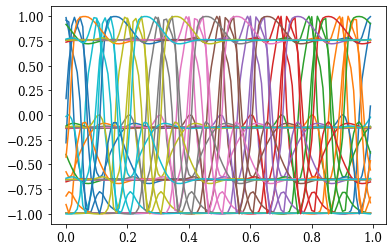

The algorithm converged to the desired accuracy. 140 46.52332933700001


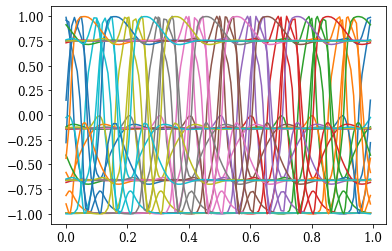

In [7]:
m0=6
m1=13
p0=times[minds[m1]]-times[minds[m0]]
Xts0=phases[minds[m0]:minds[m1]].T.copy()
ts0=(times[minds[m0]:minds[m1]]-times[minds[m0]])/p0
print(Xts0.shape,p0)
plt.plot(ts0,np.transpose(Xts0))
plt.show()

start=timeit.default_timer()
sol0=solve_bvp(lambda ts,Xts,p: p[0]*np.transpose([janus.janus(p[0]*ts[i],Xts[:,i], N, omega, sigma0, beta, gamma,sigma0,0) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[xa[0]-Xts0[0,0]]))), ts0, Xts0, p=np.array([p0]), max_nodes=500,tol=1e-1,bc_tol=1e-2)
stop=timeit.default_timer()
print(sol0.message,len(sol0.x),stop-start)
plt.plot(sol0.x,np.transpose(sol0.y))
plt.show()

### Naive continuation works. We can add bifurcation detection if we calculate Floquet exponents and continue snaking in principle.

In [ ]:
sols=[]
sigmas=[]
start=timeit.default_timer()

x0=sol0.x.copy()
y0=sol0.y.copy()
p0=sol0.p[0]
sigma=sigma0
sol=solve_bvp(lambda ts,Xts,p: p[0]*np.transpose([janus.janus(p[0]*ts[i],Xts[:,i], N, omega, sigma, beta, gamma,sigma,0) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[xa[0]-Xts0[0,0]]))), x0, y0, p=np.array([p0]), max_nodes=500,tol=1e-1,bc_tol=1e-2)
print(sol.message)

dsigma=5e-4
dsigmamax=1e-3
dsigmamin=1e-6
sigmamin=0.325
sigmamax=0.373
count=1

while sol.success and sigma<sigmamax and sigma>sigmamin:
    #We could update the initial Xts and ts with an estimate based on Jacobian and dsigma (freezing the ts to the Xts value some way)
    sols.append(sol)
    sigmas.append(sigma)
    sigma=sigma+dsigma 
    if(sigma>sigmamax):
        sigma=sigmamax
    if(sigma<sigmamin):
        sigma=sigmamin
    
    x0=sol.x
    y0=sol.y
    p0=sol.p[0]
    
    try:
        start2=timeit.default_timer()
        sol=solve_bvp(lambda ts,Xts,p: p[0]*np.transpose([janus.janus(p[0]*ts[i],Xts[:,i], N, omega, sigma, beta, gamma,sigma,0) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[xa[0]-Xts0[0,0]]))), x0, y0, p=np.array([p0]), max_nodes=500,tol=1e-1,bc_tol=1e-2)
        stop2=timeit.default_timer()

        if not sol.success:
            count=0
            raise Exception(sol.message)
        count=count+1
        if len(sol.x)>2*len(sols[-1].x):
            raise Exception('mesh increased too fast '+str(len(sol.x))+' '+str(len(sols[-1].x)))
        if (np.abs(np.max(y0)-np.max(sol.y))/np.max(y0)>5e-1):
            raise Exception('solution changed too much')
        if (np.abs((p0-sol.p[0])/p0)>5e-1):
            raise Exception('period changed too much '+ str(p0)+' '+str(sol.p[0]))
    except Exception as e:
        print('\n',str(e))
        sigma=sigma-dsigma
        dsigma=dsigma/2
        sol=sols[-1]
        print('\r%f\t%.3e\t%i\t%f\t%f\t%f\t%f\t'%(sigma, dsigma,len(sol.x),p0,sol.p[0],np.abs((p0-sol.p[0])/p0),stop2-start2),end='\n')

        if np.abs(dsigma)>dsigmamin:
            continue
        else:
            print('\nstep size too small')
            break
            
    if count>10:
        dsigma=np.sign(dsigma)*np.min([dsigmamax,np.abs(dsigma)*2])
        count=1
    print('\r%f\t%.3e\t%i\t%f\t%f\t%f\t%f\t'%(sigma, dsigma,len(sol.x),p0,sol.p[0],np.abs((p0-sol.p[0])/p0),stop2-start2),end='\n')

    
stop=timeit.default_timer()
print('\n',sol.message,len(sols),len(sols[0].x),len(sols[-1].x),stop-start)
plt.plot(sol.x,np.transpose(sol.y))
plt.show()

The algorithm converged to the desired accuracy.
0.350500	5.000e-04	246	110.187949	110.665669	0.004336	16.914560	
0.351000	5.000e-04	246	110.665669	111.150137	0.004378	17.036114	
0.351500	5.000e-04	246	111.150137	111.638198	0.004391	4.300570	
0.352000	5.000e-04	246	111.638198	112.140361	0.004498	17.265178	
0.352500	5.000e-04	246	112.140361	112.646808	0.004516	17.506040	
0.353000	5.000e-04	246	112.646808	113.161201	0.004566	13.179051	
0.353500	5.000e-04	247	113.161201	113.683939	0.004619	17.594109	
0.354000	5.000e-04	247	113.683939	114.213564	0.004659	8.816761	
0.354500	5.000e-04	247	114.213564	114.752113	0.004715	4.290009	
0.355000	1.000e-03	251	114.752113	115.307650	0.004841	43.837519	
0.356000	1.000e-03	254	115.307650	116.440004	0.009820	56.645495	
0.357000	1.000e-03	254	116.440004	117.615131	0.010092	19.111660	
0.358000	1.000e-03	255	117.615131	118.840386	0.010417	33.204251	


In [ ]:
sols2=[]
sigmas2=[]
start=timeit.default_timer()

x0=sol0.x.copy()
y0=sol0.y.copy()
p0=sol0.p[0]
sigma=sigma0
sol=solve_bvp(lambda ts,Xts,p: p[0]*np.transpose([janus.janus(p[0]*ts[i],Xts[:,i], N, omega, sigma, beta, gamma,sigma,0) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[xa[0]-Xts0[0,0]]))), x0, y0, p=np.array([p0]), max_nodes=500,tol=1e-1,bc_tol=1e-2)
print(sol.message)

dsigma=-5e-4
dsigmamax=1e-3
dsigmamin=1e-6
sigmamin=0.25
sigmamax=0.373
count=1

while sol.success and sigma<sigmamax and sigma>sigmamin:
    #We could update the initial Xts and ts with an estimate based on Jacobian and dsigma (freezing the ts to the Xts value some way)
    sols2.append(sol)
    sigmas2.append(sigma)
    sigma=sigma+dsigma 
    if(sigma>sigmamax):
        sigma=sigmamax
    if(sigma<sigmamin):
        sigma=sigmamin
    
    x0=sol.x.copy()
    y0=sol.y.copy()
    p0=sol.p[0]
    
    try:
        start2=timeit.default_timer()
        sol=solve_bvp(lambda ts,Xts,p: p[0]*np.transpose([janus.janus(p[0]*ts[i],Xts[:,i], N, omega, sigma, beta, gamma,sigma,0) for i in range(len(ts))]), lambda xa,xb,p: (np.concatenate((xb-xa,[xa[0]-Xts0[0,0]]))), x0, y0, p=np.array([p0]), max_nodes=500,tol=1e-1,bc_tol=1e-2)        
        stop2=timeit.default_timer()

        if not sol.success:
            count=0
            raise Exception(sol.message)
        count=count+1
        if len(sol.x)>2*len(sols2[-1].x):
            raise Exception('mesh increased too fast '+str(len(sol.x))+' '+str(len(sols[-1].x)))
        if (np.abs(np.max(y0)-np.max(sol.y))/np.max(y0)>5e-1):
            raise Exception('solution changed too much')
        if (np.abs((p0-sol.p[0])/p0)>5e-1):
            raise Exception('period changed too much '+ str(p0)+' '+str(sol.p[0]))
    except Exception as e:
        print('\n',str(e))
        sigma=sigma-dsigma
        dsigma=dsigma/2
        sol=sols[-1]
        print('\r%f\t%.3e\t%i\t%f\t%f\t%f\t%f\t'%(sigma, dsigma,len(sol.x),p0,sol.p[0],np.abs((p0-sol.p[0])/p0),stop2-start2),end='\n')

        if np.abs(dsigma)>dsigmamin:
            continue
        else:
            print('\nstep size too small')
            break
            
    if count>10:
        dsigma=np.sign(dsigma)*np.min([dsigmamax,np.abs(dsigma)*2])
        count=1
    print('\r%f\t%.3e\t%i\t%f\t%f\t%f\t%f\t'%(sigma, dsigma,len(sol.x),p0,sol.p[0],np.abs((p0-sol.p[0])/p0),stop2-start2),end='\n')

    
stop=timeit.default_timer()
print('\n',sol.message,len(sols2),len(sols2[0].x),len(sols2[-1].x),stop-start)
plt.plot(sol.x,np.transpose(sol.y))
plt.show()

In [ ]:
phases=sols2[-1].y.T.copy()
phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
plt.matshow([np.cos(np.roll(theta[:,i], 100+int(len(theta)/N*i))) for i in range(N)],aspect=len(phi)/len(phi[0]),cmap='twilight')
plt.show()
plt.plot(np.transpose([np.cos(np.roll(theta[:,i], 100+int(len(theta)/N*i))) for i in range(N)]))
plt.show()

In [ ]:
orders=[]
u0s=[]
periods=[]
for i in range(len(sols)):
    phases=sols[i].y.T.copy()
    phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
    theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
    r=np.abs(np.sum(phases[:,:N]+1j*phases[:,N:2*N],axis=1)+np.sum(phases[:,2*N:3*N]+1j*phases[:,3*N:],axis=1))/(2*N)
    orders.append(np.sum(r[:-1]*np.diff(sols[i].x)))
    u0s.append(np.sum(np.cos(phi[:,0]-theta[:,0])[:-1]*np.diff(sols[i].x)))
    periods.append(sols[i].p[0])
    
orders2=[]
u0s2=[]
periods2=[]
for i in range(len(sols2)):
    phases=sols2[i].y.T.copy()
    phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
    theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
    r=np.abs(np.sum(phases[:,:N]+1j*phases[:,N:2*N],axis=1)+np.sum(phases[:,2*N:3*N]+1j*phases[:,3*N:],axis=1))/(2*N)
    orders2.append(np.sum(r[:-1]*np.diff(sols2[i].x)))
    u0s2.append(np.sum(np.cos(phi[:,0]-theta[:,0])[:-1]*np.diff(sols2[i].x)))
    periods2.append(sols2[i].p[0])
plt.plot(sigmas2,orders2)
plt.plot(sigmas,orders)
plt.show()
plt.plot(sigmas2,periods2)
plt.plot(sigmas,periods)
plt.show()
plt.plot(sigmas2,u0s2)
plt.plot(sigmas,u0s)
plt.show()

In [ ]:
Sigmas=[sigmas2[-i] for i in range(1,len(sols2))]+[sigmas[i] for i in range(len(sols))]
Periods=[sols2[-i].p[0] for i in range(1,len(sols2))]+[sols[i].p[0] for i in range(len(sols))]
Ts=[sols2[-i].x for i in range(1,len(sols2))]+[sols[i].x for i in range(len(sols))]
Ys=[sols2[-i].y for i in range(1,len(sols2))]+[sols[i].y for i in range(len(sols))]
np.save(filebase+'lcsigmas.npy',Sigmas)
np.save(filebase+'lcperiods.npy',Periods)
for i in range(len(Sigmas)):
    np.save(filebase+'lctimes_'+str(i)+'.npy',Ts[i])
    np.save(filebase+'lcphases_'+str(i)+'.npy',Ys[i])

In [ ]:
Orders=[]
for i in len(Ys):
    phases=Ys[i].T.copy()
    phi=np.arctan2(phases[:,3*N:],phases[:,2*N:3*N])
    theta=np.arctan2(phases[:,N:2*N],phases[:,:N])
    r=np.abs(np.sum(phases[:,:N]+1j*phases[:,N:2*N],axis=1)+np.sum(phases[:,2*N:3*N]+1j*phases[:,3*N:],axis=1))/(2*N)
    Orders.append(np.sum(r[:-1]*np.diff(Ts[i])))
plt.plot(Sigmas,Orders)

In [ ]:
plt.plot(Sigmas,Periods)
plt.show()
plt.plot(Sigmas,Orders)
plt.show()